In [1]:
import tensorflow as tf

In [2]:
import tensorflow.keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten , Conv2D, Dropout, BatchNormalization, ReLU
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
import time
from math import trunc
import matplotlib.pyplot as plt

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
(x_train, y_train), (x_val, y_val) = mnist.load_data()

# Ajout de l'indication du canal sur le images pour le traitement via réseau convolutionnel
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_val = x_val.reshape(x_val.shape[0], 28, 28, 1)

input_shape=(28, 28, 1)
num_classes = 10

# normalisation
x_train, x_val = x_train/255., x_val/255.
# 1-hot encoding
y_train, y_val = to_categorical(y_train, dtype='int8'), to_categorical(y_val, dtype='int8')

11493376/11490434 [==============================] - 2s 0us/step


In [5]:
# Hyperparamètres
#
# Nombre d'époques pour l'apprentissage:
epochs = 30

# Taille du batch d'entraînement:
batch_size = 100

# Taux de dropout rate
dropout_rate = 0.1

# Planification de l'apprentissage
initial_learning_rate = 0.005
# taux de décroissance du pas d'apprentissage
decay_rate = 0.7
# Nombre d'époques à faire avant de changer de pas
decay_steps = 180000 # 3 époques

In [6]:
# Structure du modèle

model = Sequential()
model.add(Conv2D(12, kernel_size=(6,6), input_shape=input_shape))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(dropout_rate))

model.add(Conv2D(12, (5,5), strides=(2, 2)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(dropout_rate))

model.add(Conv2D(24, (4,4), strides=(2, 2)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(dropout_rate))

model.add(Flatten())

model.add(Dense(200, activation='relu'))
model.add(Dropout(dropout_rate))

model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 23, 23, 12)        444       
_________________________________________________________________
batch_normalization (BatchNo (None, 23, 23, 12)        48        
_________________________________________________________________
re_lu (ReLU)                 (None, 23, 23, 12)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 12)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 12)        3612      
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 12)        48        
_________________________________________________________________
re_lu_1 (ReLU)               (None, 10, 10, 12)        0

In [7]:
# Planification de l'apprentissage

lr_schedule = ExponentialDecay(initial_learning_rate,
            decay_steps = decay_steps,
            decay_rate = decay_rate,
            staircase=True)

optimizer = Adam(learning_rate=lr_schedule)

model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizer,
              metrics = ['accuracy'])

In [8]:
heure_de_debut = time.time()
historique = model.fit(x_train, y_train,
                       batch_size=batch_size,
                       epochs=epochs,
                       verbose=1,
                       validation_data=(x_val, y_val))

temps_de_calcul = time.time() - heure_de_debut
print("Temps de calcul: {:d} s".format(trunc(temps_de_calcul)))

Epoch 1/30
600/600 [==============================] - 2s 4ms/step - loss: 0.1513 - accuracy: 0.9532 - val_loss: 0.0660 - val_accuracy: 0.9789
Epoch 2/30
600/600 [==============================] - 2s 3ms/step - loss: 0.0617 - accuracy: 0.9822 - val_loss: 0.0443 - val_accuracy: 0.9860
Epoch 3/30
600/600 [==============================] - 2s 3ms/step - loss: 0.0488 - accuracy: 0.9852 - val_loss: 0.0377 - val_accuracy: 0.9880
Epoch 4/30
600/600 [==============================] - 2s 3ms/step - loss: 0.0427 - accuracy: 0.9865 - val_loss: 0.0405 - val_accuracy: 0.9878
Epoch 5/30
600/600 [==============================] - 2s 3ms/step - loss: 0.0362 - accuracy: 0.9886 - val_loss: 0.0332 - val_accuracy: 0.9903
Epoch 6/30
600/600 [==============================] - 2s 3ms/step - loss: 0.0332 - accuracy: 0.9897 - val_loss: 0.0262 - val_accuracy: 0.9919
Epoch 7/30
600/600 [==============================] - 2s 3ms/step - loss: 0.0295 - accuracy: 0.9903 - val_loss: 0.0291 - val_accuracy: 0.9915
Epoch 

In [9]:
model.evaluate(x_val, y_val, verbose=0)

[0.03095921315252781, 0.9926999807357788]

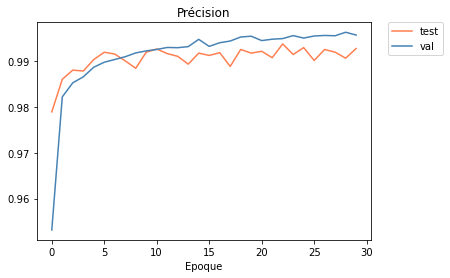

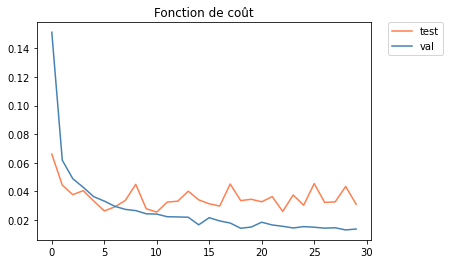

In [10]:
# Représentation des résultats
accuracy_train = historique.history['accuracy']
accuracy_test = historique.history['val_accuracy']
loss_train = historique.history['loss']
loss_test = historique.history['val_loss']
# Précision
plt.plot(accuracy_test, c='coral', label='test')
plt.plot(accuracy_train, c='steelblue', label='val')
plt.xlabel('Epoque')
plt.title('Précision')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
# Fonction de coût
plt.plot(loss_test, c='coral', label='test')
plt.plot(loss_train, c='steelblue', label='val')
plt.title('Fonction de coût')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()